## Aim:

We aim to come up with a model that simulates the temperature drop along time inside the box.

Like this eventually we can have for a give critical temperature, the remaining delivery time.
    

## Experimental Setup
We simulate the transportation box. We add the water/ice stable conditions where the critical products have to be transported.

<img style="float:left;transform: width:300px" src="pics/icebox4.png" />

In [94]:
#necessary libs
import pandas as pd
import numpy as np

import scipy.optimize 
import scipy as sp

import matplotlib.pyplot as plt
%matplotlib inline

## Read Data

In [69]:
ambient = pd.read_csv('icebox_data/ambient_conditions.csv', delimiter=';')
ambient.index = pd.to_datetime(ambient['datetime']).values

icebox = pd.read_csv('icebox_data/icebox_conditions.csv')
icebox.index = pd.to_datetime(icebox['datetime']).values

# resample the time series
ambient = ambient.resample('5Min').mean()
icebox = icebox.resample('5Min').mean()

# join all in a single dataframe
temp = ambient[['Temperature']].rename(columns={'Temperature': 'T [ambient]'})\
    .join(icebox[['Temperature']].rename(columns={'Temperature': 'T [icebox]'}),  
          how='inner')

# keep the interesting part
temp = temp['2018-06-27 19:30:00':]

temp.head(4)

,T [ambient],T [icebox]
2018-06-27 19:30:00,26.7,5.93
2018-06-27 19:35:00,26.4,6.10
2018-06-27 19:40:00,26.2,6.03
2018-06-27 19:45:00,NaN,5.91


## plot data

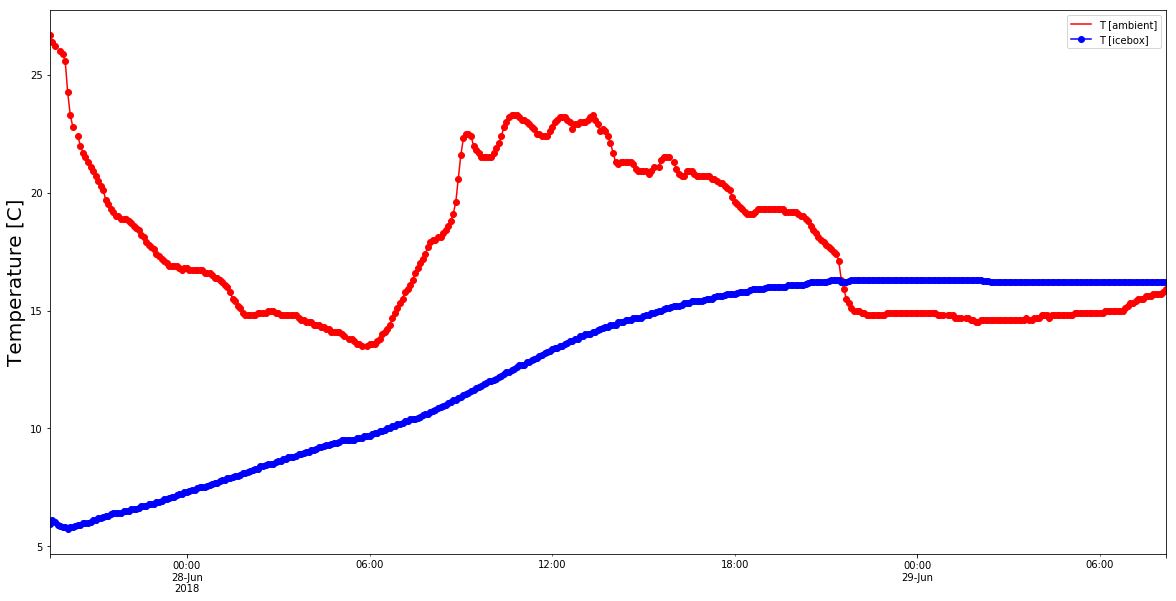

In [95]:
fig = plt.figure(figsize=(20,10)) 
ax = plt.subplot()
_ = temp[['T [ambient]']].plot(ax=ax, color='red', marker='o')
_ = temp[['T [icebox]']].plot(ax=ax, color='blue', marker='o')
_ = ax.set_ylabel('Temperature [C]', fontsize=20)
_ = ax.set_xlabel('', fontsize=0)

## Modeling the Thermodinamic properties 

5.61833344812 -0.083575890002 16.942696356


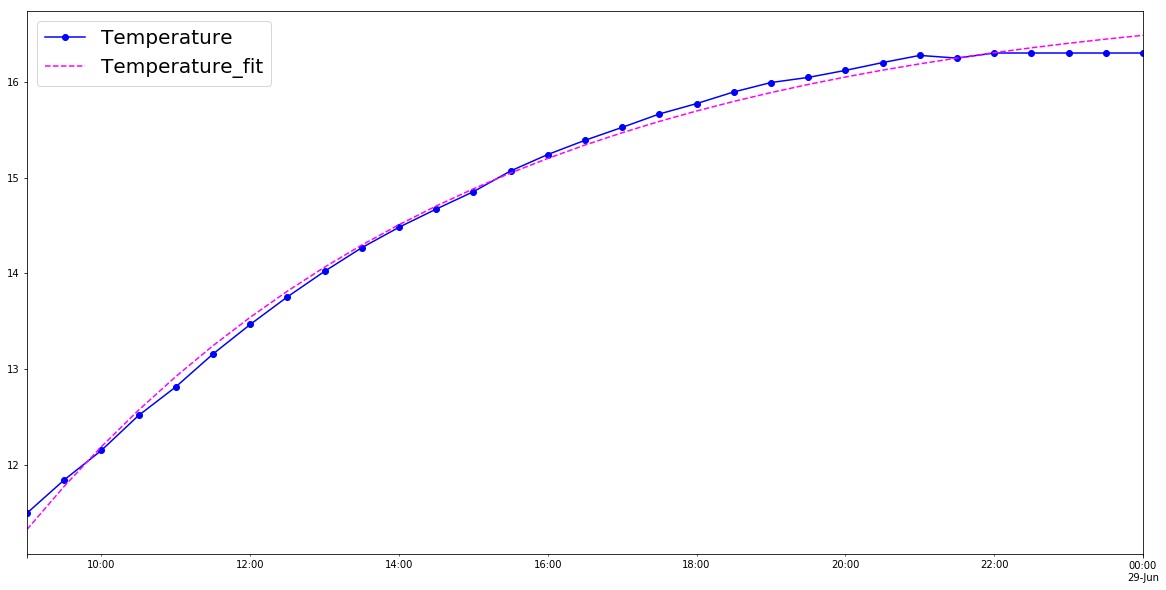

In [265]:

icebox_mod = icebox.resample('30Min').mean()

# hack
# the outside temperature change during night/day affects quite a lot the inside temperature
# Lets remove this complication and approximate that the real rides happen during day (which is true)
icebox_mod = icebox_mod['2018-06-28 09:00:00': '2018-06-29 00:00:00']

# we add a ctr useful for the fit
icebox_mod['t_step']  = range(len(icebox_mod))

# fig = plt.figure(figsize=(20,10)) 
# ax = plt.subplot()
# _ = icebox_mod[['Temperature']].plot(ax=ax, color='blue', marker = 'o')


def model_func(t, A, k, B):
    return -1*A * np.exp(k * t) + B

opt_parms, parm_cov = sp.optimize.curve_fit(model_func, 
                                            icebox_mod['t_step'].values, 
                                            icebox_mod['Temperature'].values, 
                                            p0=[5, -0.1, 16], 
                                            maxfev=1000)
A, k, B = opt_parms


icebox_mod['Temperature_fit'] = icebox_mod['t_step'].apply(lambda x: model_func(x, A, k, B ))

# PLOT 
# for plot purposes translate index into elapsed time (min)
icebox_mod
fig = plt.figure(figsize=(20,10)) 
ax = plt.subplot()
actual_temp = icebox_mod['Temperature'].plot(ax=ax, color='blue', marker='o', legend='actual temperature')
fit_temp = icebox_mod['Temperature_fit'].plot(ax=ax, color='magenta', legend = 'fit temperature', style='--')
_ = plt.legend(fontsize=20)

## Extract the remaining critical time

e.g.
- critical temperature @ 3 Celcium degrees

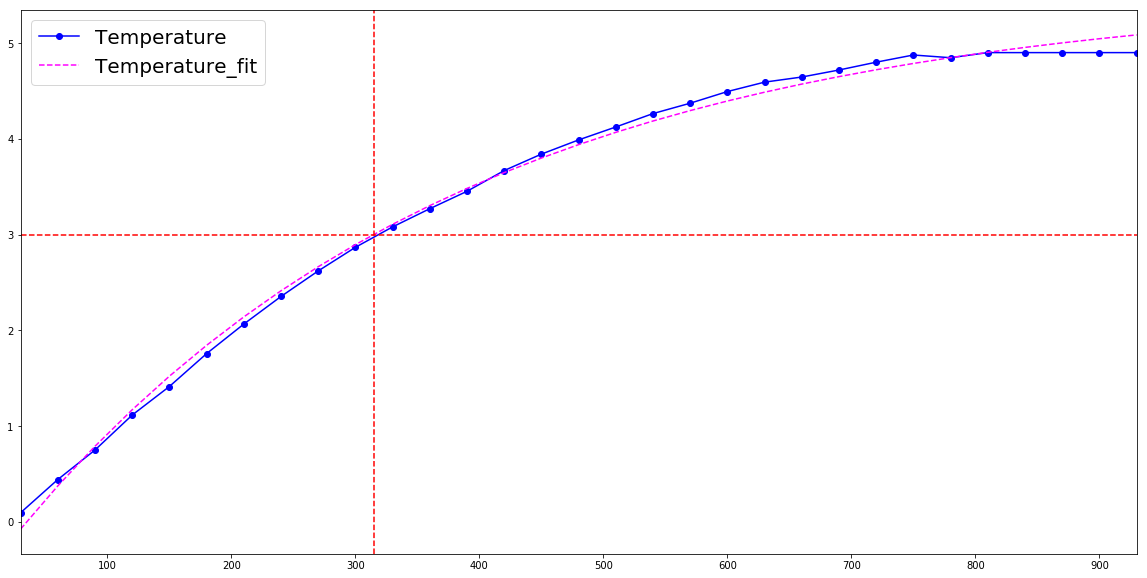

In [292]:
icebox_mod = icebox.resample('30Min').mean()

icebox_mod = icebox_mod['2018-06-28 09:00:00': '2018-06-29 00:00:00']

# we add a ctr useful for the fit
icebox_mod['t_step']  = range(len(icebox_mod))
# hacks

# lets shift a bit the temperature so we start @ 0 degrees - where the ice/water latent temp is. 
# Nothing bad here, this is our eventual goal and doable.

icebox_shifted = icebox_mod
icebox_shifted['Temperature'] = icebox_shifted['Temperature'] - 11.4


# we add a ctr useful for the fit
icebox_shifted['t_step']  = range(len(icebox_shifted))

def model_func(t, A, k, B):
    return -1*A * np.exp(k * t) + B

opt_parms, parm_cov = sp.optimize.curve_fit(model_func, 
                                            icebox_shifted['t_step'].values, 
                                            icebox_shifted['Temperature'].values, 
                                            p0=[5, -0.1, 16], 
                                            maxfev=1000)
A, k, B = opt_parms


icebox_shifted['Temperature_fit'] = icebox_shifted['t_step'].apply(lambda x: model_func(x, A, k, B ))

# add an index which shows that the elapsed time after the ride start
idx = 0
idxs = []
for i in range(len(icebox_mod)):
    idx += 30
    idxs.append(idx)
icebox_shifted.index = idxs

# for plot purposes translate index into elapsed time (min)
fig = plt.figure(figsize=(20,10)) 
ax = plt.subplot()
actual_temp = icebox_shifted['Temperature'].plot(ax=ax, color='blue', marker='o', legend='actual temperature')
fit_temp = icebox_shifted['Temperature_fit'].plot(ax=ax, color='magenta', legend = 'fit temperature', style='--')
_ = plt.legend(fontsize=20)


# The critical temperature 
_ = plt.axhline(y=3.0, color='r', linestyle='--')

# The relevant critical time
_ = plt.axvline(x=315, color='r', linestyle='--')

#plt.show()


So for the given conditions, under the hypothesis that the product inside the box has to be delivered before its temperature reaches 3 degrees C, the remaining critical time is ~310 minutes!